In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()
from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Spice.Netlist import Circuit,SubCircuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Unit import *
from PySpice.Probe.Plot import plot
from PySpice.Logging.Logging import setup_logging
from multiprocessing import Pool
from PySpice.Spice.NgSpice.Shared import NgSpiceShared
import random
setup_logging()

libraries_path = find_libraries()
spice_library = SpiceLibrary(libraries_path)

In [2]:
def generate_random_mn(M, N, num_pairs):
    special_mn = set()
    
    if M < 3 or N < 3:
        raise ValueError("Both M and N should be at least 3")

    while len(special_mn) / 9 < num_pairs:
        m = random.randint(0, M-3)
        n = random.randint(0, N-3)

        # Add the nine pairs
        for i in range(3):
            for j in range(3):
                special_mn.add((m+i, n+j))

    return list(special_mn)


In [3]:
M = 364
N = 91
w = 0.0025
l = 0.0025

In [4]:
def create_tandem_array(M, N, special_mn):
    
    circuit = Circuit('Perovskite/Silicon Tandem Equivalent Circuit')
    
    circuit.model('D1_top', 'D', IS = 8.8e-23*(w*l), N =1)
    circuit.model('D2_top', 'D', IS = 2.62e-13*(w*l), N =2)
    circuit.model('D1_bot', 'D', IS=1.3339e-14*(w*l), N =1)
    circuit.model('D2_bot', 'D', IS=6.5674e-19*(w*l), N =2)
    circuit.V('1', 'input', circuit.gnd, 1.646@u_V)

    for m in range(M):
        for n in range(N):
            name_prefix = f"{m:03d}{n:03d}"
            is_special = (m, n) in special_mn
            
            # Metal Sheet Resistance
            if m == 0:
                circuit.R(f'Metal_sheet_input{n:03d}', 'input', f'q{m:03d}{n:03d}', 2.13*l/w@u_mOhm)
            if ( m == 1 and 0 < n < 91) or (m > 1 and  n == 45):
                circuit.R(f'Metal_sheet_v{m:03d}{n:03d}', f'q{m-1:03d}{n:03d}', f'q{m:03d}{n:03d}', 2.13*l/w@u_mOhm)
                circuit.R(f'Metal_sheet_h{m:03d}{n:03d}', f'q{m:03d}{n-1:03d}', f'q{m:03d}{n:03d}', 2.13*w/l@u_mOhm)
                circuit.R(f'c_metal_{name_prefix}', f'q{m:03d}{n:03d}', f'a{m:03d}{n:03d}', 5/(w*l)@u_mOhm)            
            
                
            # ITO Sheet Resistance
            
            if m > 0:
                circuit.R(f'ITO_sheet_v{m:03d}{n:03d}', f'a{m-1:03d}{n:03d}', f'a{m:03d}{n:03d}', 55*l/w@u_Ohm).plus.add_current_probe(circuit)
            if n > 0:
                circuit.R(f'ITO_sheet_h{m:03d}{n:03d}', f'a{m:03d}{n-1:03d}', f'a{m:03d}{n:03d}', 55*w/l@u_Ohm).plus.add_current_probe(circuit)

            # RJ Sheet Resistance
            if m > 0:
                circuit.R(f'RJ_sheet_v{m:03d}{n:03d}', f'd{m-1:03d}{n:02d}', f'd{m:03d}{n:03d}', 200*l/w@u_Ohm).plus.add_current_probe(circuit)
            if n > 0:
                circuit.R(f'RJ_sheet_h{m:03d}{n:03d}', f'd{m:03d}{n-1:03d}', f'd{m:03d}{n:03d}', 200*w/l@u_Ohm).plus.add_current_probe(circuit)

            # Top Cell
            
            circuit.R(f's_top_{name_prefix}', f'a{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 2/(w*l)@u_Ohm)
            circuit.D(f'1_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', model='D1_top')
            circuit.D(f'2_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', model='D2_top')
            if is_special:
                circuit.R(f'sh_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', 2/(w*l)@u_Ohm)
                
            else:
                circuit.R(f'sh_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', 5.55/(w*l)@u_kOhm)
                
            if (m < 2 and n < 91) or (m > 1 and  n == 45):
                circuit.I(f'ph_top_{name_prefix}', f'c{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 0*(w*l)@u_mA)
            else:
                circuit.I(f'ph_top_{name_prefix}', f'c{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 19.65*(w*l)@u_mA)

            # Connection
            circuit.R(f'c_top_{name_prefix}', f'c{m:03d}{n:03d}', f'd{m:03d}{n:03d}', 0/(w*l)@u_mOhm)
            circuit.R(f'c_bot_{name_prefix}', f'd{m:03d}{n:03d}', f'e{m:03d}{n:03d}', 0/(w*l)@u_mOhm)

            # Bottom Cell
            circuit.R(f's_bot_{name_prefix}', f'e{m:03d}{n:03d}', f'f{m:03d}{n:03d}', 0.2/(w*l)@u_Ohm)
            circuit.D(f'1_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, model='D1_bot')
            circuit.D(f'2_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, model='D2_bot')
            circuit.R(f'sh_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, 12/(w*l)@u_kOhm)
            if (m < 2 and n < 91) or (m > 1 and  n == 45):
                circuit.I(f'ph_bot_{name_prefix}', circuit.gnd, f'f{m:03d}{n:03d}', 0*(w*l)@u_mA)
            else:
                circuit.I(f'ph_bot_{name_prefix}', circuit.gnd, f'f{m:03d}{n:03d}', 19.65*(w*l)@u_mA)

    return circuit

In [5]:
num_pairs = 64  # Set num_pairs to 330

special_mn = generate_random_mn(M, N, num_pairs)
circuit = create_tandem_array(M, N, special_mn)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
%time analysis = simulator.operating_point()

CPU times: total: 23min 57s
Wall time: 24min 15s


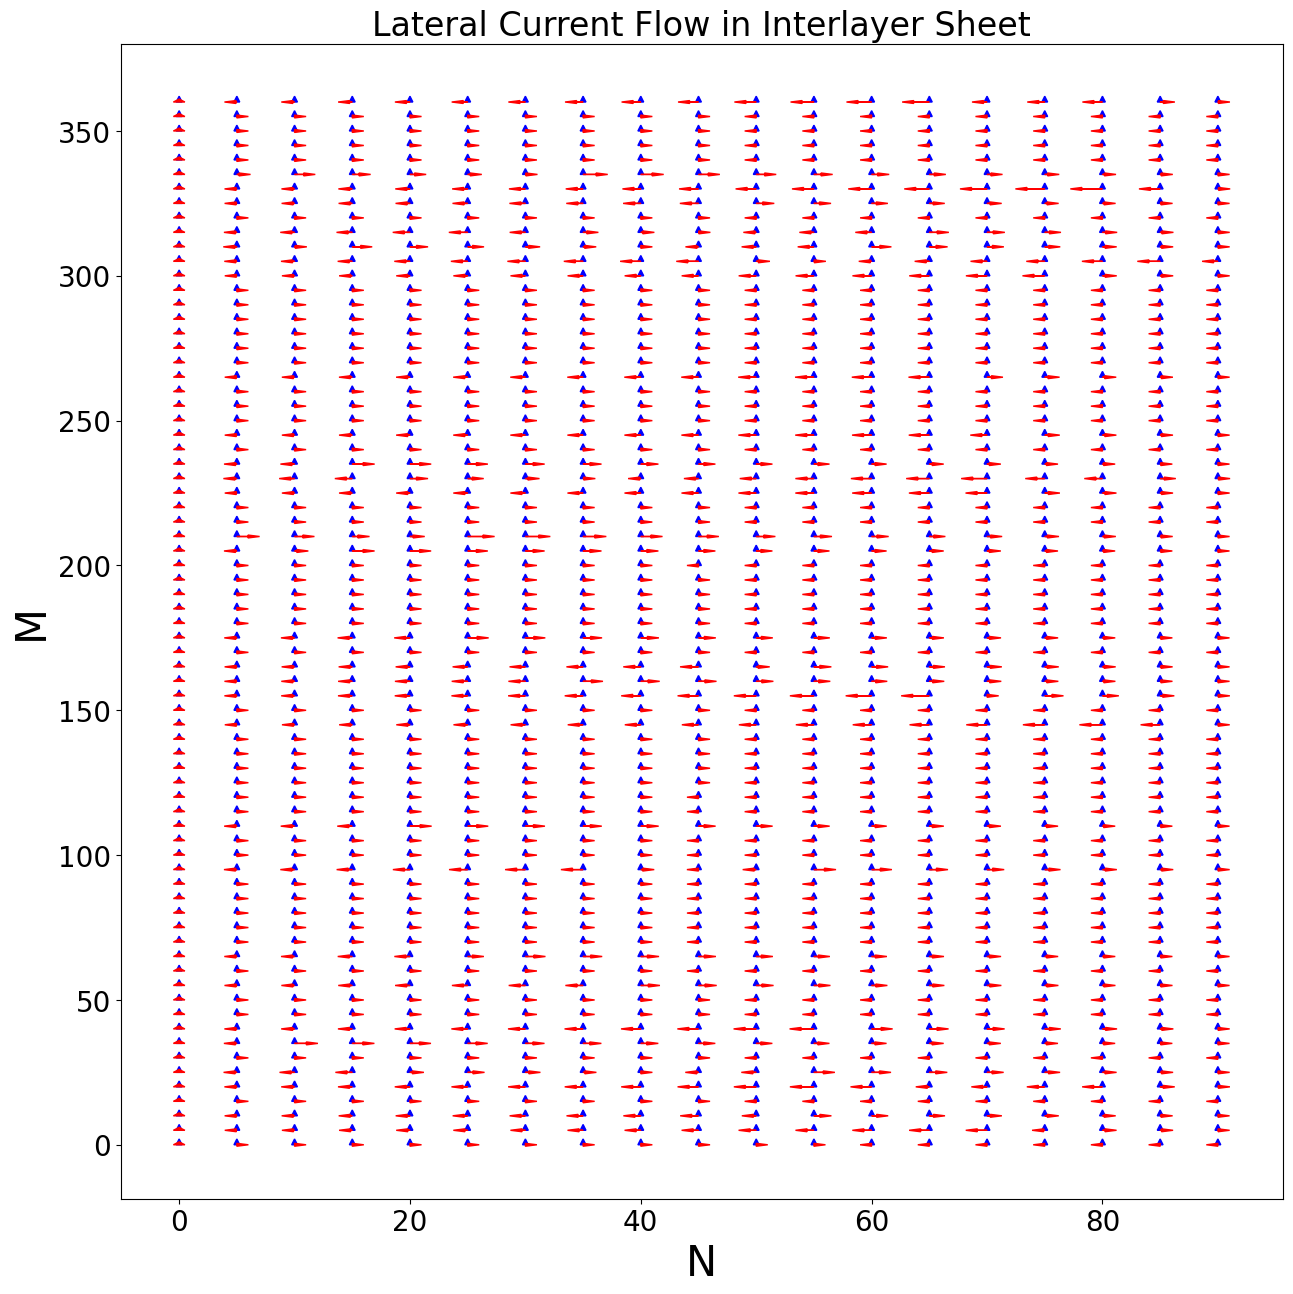

Max value in rj_sheet_currents_v: 0
Max value in rj_sheet_currents_h: 5.106464088389193e-06


In [6]:
rj_sheet_currents_v = [[0 for _ in range(N)] for _ in range(M)] # 세로 방향 전류
rj_sheet_currents_h = [[0 for _ in range(N)] for _ in range(M)] # 가로 방향 전류

for m in range(M):
    for n in range(N):
        name_prefix = f"{m:03d}{n:03d}"
        if m > 0:
            current_value_v = analysis.branches[f'vrrj_sheet_v{name_prefix}_plus'].as_ndarray()
            rj_sheet_currents_v[m][n] = current_value_v[0] # 2차원 배열에 저장
        if n > 0:
            current_value_h = analysis.branches[f'vrrj_sheet_h{name_prefix}_plus'].as_ndarray()
            rj_sheet_currents_h[m][n] = current_value_h[0] # 2차원 배열에 저장

            
from matplotlib.patches import FancyArrowPatch

def plot_combined_current_flow(rj_sheet_currents_v, rj_sheet_currents_h):
    fig, ax = plt.subplots(figsize=(15, 15))

    step = 5 # 5개 간격으로 샘플링
    M = len(rj_sheet_currents_v)
    N = len(rj_sheet_currents_v[0])
    max_current = max(max(np.abs(c) for c in row) for row in rj_sheet_currents_v + rj_sheet_currents_h)

    for m in range(0, M, step):
        for n in range(0, N, step):
            current_v = rj_sheet_currents_v[m][n]
            current_h = rj_sheet_currents_h[m][n]
            normalized_length_v = np.abs(current_v) / max_current
            normalized_length_h = np.abs(current_h) / max_current

            length_v = 10*normalized_length_v # 길이 2배 조정
            length_h = 2*normalized_length_h # 길이 2배 조정

            arrow_dir_v = (0, length_v if current_v > 0 else -length_v) # 세로 방향 화살표
            arrow_dir_h = (length_h if current_h > 0 else -length_h, 0) # 가로 방향 화살표

            plt.arrow(n, m, *arrow_dir_v, head_width=0.5, head_length=2, fc='blue', ec='blue') # 세로 화살표 그리기
            plt.arrow(n, m, *arrow_dir_h, head_width=1, head_length=1, fc='red', ec='red')  # 가로 화살표 그리기

    ax.tick_params(axis='both', which='major', labelsize=20)  # 주 눈금의 글자 크기를 14로 설정
    ax.tick_params(axis='both', which='minor', labelsize=20)  # 부 눈금의 글자 크기를 12로 설정
    plt.title("Lateral Current Flow in Interlayer Sheet", fontsize = 24)
    plt.xlabel("N", fontsize = 30)
    plt.ylabel("M", fontsize = 30)
    plt.show()

plot_combined_current_flow(rj_sheet_currents_v, rj_sheet_currents_h)

print("Max value in rj_sheet_currents_v:", max(max(row) for row in rj_sheet_currents_v))
print("Max value in rj_sheet_currents_h:", max(max(row) for row in rj_sheet_currents_h))


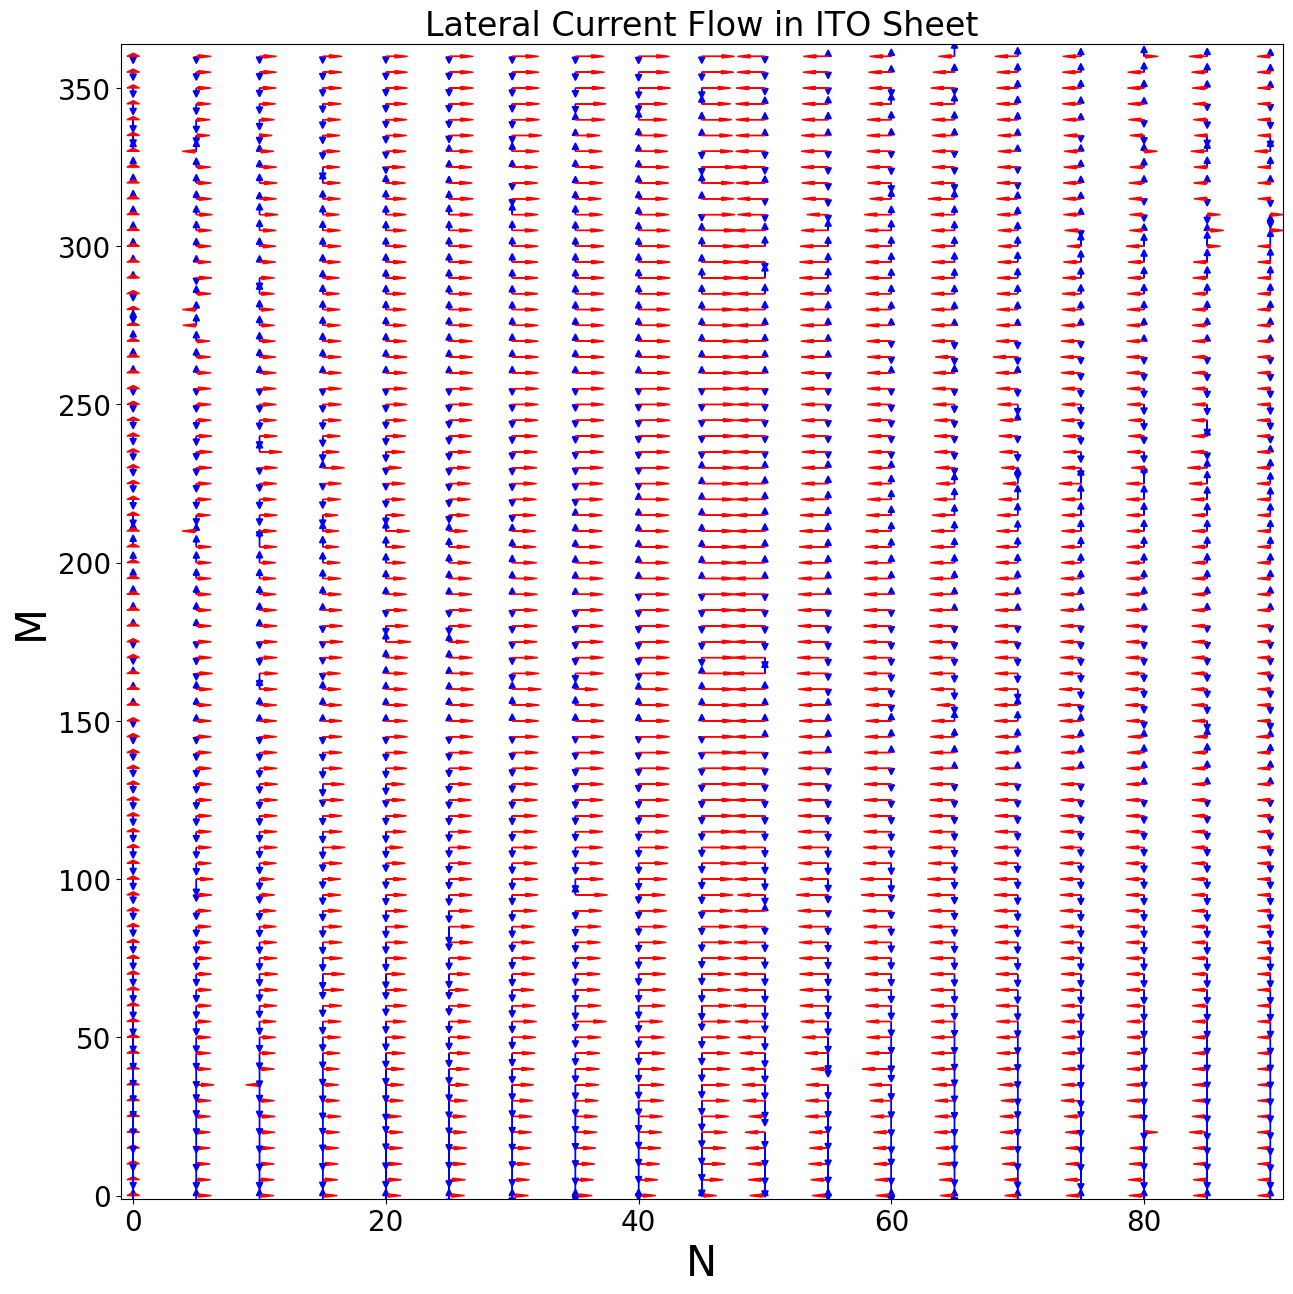

Max value in rj_sheet_currents_v: 2.4531293021240463e-06
Max value in rj_sheet_currents_h: 4.946844061260586e-06


In [7]:
ito_sheet_currents_v = [[0 for _ in range(N)] for _ in range(M)] # 세로 방향 전류
ito_sheet_currents_h = [[0 for _ in range(N)] for _ in range(M)] # 가로 방향 전류

for m in range(M):
    for n in range(N):
        name_prefix = f"{m:03d}{n:03d}"
        if m > 0:
            current_value_v = analysis.branches[f'vrito_sheet_v{name_prefix}_plus'].as_ndarray()
            ito_sheet_currents_v[m][n] = current_value_v[0] # 2차원 배열에 저장
        if n > 0:
            current_value_h = analysis.branches[f'vrito_sheet_h{name_prefix}_plus'].as_ndarray()
            ito_sheet_currents_h[m][n] = current_value_h[0] # 2차원 배열에 저장

            
def plot_combined_current_flow(ito_sheet_currents_v, ito_sheet_currents_h):
    fig, ax = plt.subplots(figsize=(15, 15))

    step = 5 # 5개 간격으로 샘플링
    M = len(ito_sheet_currents_v)
    N = len(ito_sheet_currents_v[0])
    max_current = max(max(np.abs(c) for c in row) for row in ito_sheet_currents_v + ito_sheet_currents_h)

    for m in range(0, M, step):
        for n in range(0, N, step):
            current_v = ito_sheet_currents_v[m][n]
            current_h = ito_sheet_currents_h[m][n]
            normalized_length_v = np.abs(current_v) / max_current
            normalized_length_h = np.abs(current_h) / max_current

            length_v = 10*normalized_length_v # 길이 2배 조정
            length_h = 2*normalized_length_h # 길이 2배 조정

            arrow_dir_v = (0, length_v if current_v > 0 else -length_v) # 세로 방향 화살표
            arrow_dir_h = (length_h if current_h > 0 else -length_h, 0) # 가로 방향 화살표

            plt.arrow(n, m, *arrow_dir_v, head_width=0.5, head_length=2, fc='blue', ec='blue') # 세로 화살표 그리기
            plt.arrow(n, m, *arrow_dir_h, head_width=1, head_length=1, fc='red', ec='red')  # 가로 화살표 그리기

    plt.ylim(-1, M)
    plt.xlim(-1, N)
    ax.tick_params(axis='both', which='major', labelsize=20)  # 주 눈금의 글자 크기를 14로 설정
    ax.tick_params(axis='both', which='minor', labelsize=20)  # 부 눈금의 글자 크기를 12로 설정
    plt.title("Lateral Current Flow in ITO Sheet", fontsize = 24)
    plt.xlabel("N", fontsize = 30)
    plt.ylabel("M", fontsize = 30)
    plt.show()

plot_combined_current_flow(ito_sheet_currents_v, ito_sheet_currents_h)

print("Max value in rj_sheet_currents_v:", max(max(row) for row in ito_sheet_currents_v))
print("Max value in rj_sheet_currents_h:", max(max(row) for row in ito_sheet_currents_h))